# Kerék odometria kibővített (EKF) Kálmán-szűrővel

## Csúszás nélkül gördülő kerék

### A mozgás összefüggéseinek felírása

*A munkafüzet (Kalman1.ipnb) és a hozzá tartozó állományok* (./img/\*, ./dat/a.txt) *interaktívan futtathatók, módosíthatók a [tmpnb.org](https://tmpnb.org/)-ra feltöltés után. Vigyázat! Ott 10 perc inaktivitás után törlődnek az állományok, ezért a változtatásokat célszerű lementeni.*

GitHub repo, ahonnan letölthetők a szükséges állományok ([repo](https://github.com/gyulat/odometry-EKF))

* Kalman1.ipnb
* ./img/*.png
* ./dat/a.txt

A *csúszás nélkül* gördülő kerék mozgása egyenes haladásból és forgásból áll. A pillanatnyi érintkezési pont zérus sebességű, ahogy az ábráról látható:

<img src="./img/gordul1.png" />

Az ábrán látható $r_w$ sugarú kerék O középpontjától $r_s$ távolságban rögzített kéttengelyű S gyorsulásmérő szenzor 1. tengelye a sugárra merőlegesen a pozitív forgásirányban (óramutató járásával megegyezően), 2. tengelye a sugár irányában, az O középpont felé mutat. 

<img src="./img/gordul2.png" />

A $\mathbf{g}$ nehézségi gyorsulás vektornak a szenzor tengelyirányaiba mutató összetevői:

$$a_1=-g\sin(\theta)$$
$$a_2=-g\cos(\theta)$$.

Az O középpontban $\ddot{p}$ lineáris gyorsulással haladó kerék esetében az S szenzor érzékelő tömegére ellenkező irányú gyorsulás hat az ábra szerint

<img src="./img/gordul3.png" />

melynek összetevői:

$$a_1=\ddot{p}\cos(\theta)$$
$$a_2=-\ddot{p}\sin(\theta)$$.



Végül a kerék gyorsuló forgása miatt fellép $a_1$ irányában centripetális, $a_2$ irányában centrifugális gyorsulás.

<img src="./img/gordul4.png" />

A kerék csúszás mentes gördülése miatt a $\theta$ elfordulási szög, a $\dot\theta$ szögsebesség és a $\ddot\theta$ szöggyorsulás kapcsolatban van a megtett $p$ úttal, a $\dot{p}$ haladási sebességgel és a $\ddot{p}$ lineáris gyorsulással:

$$\theta=\frac{p}{r_w}$$
$$\dot\theta=\frac{\dot{p}}{r_w}$$
$$\ddot\theta=\frac{\ddot{p}}{r_w}$$

A szenzor tengelyei irányában fellépő gyorsulások tehát

$$a_1=-r_s \ddot\theta = -\frac{r_s}{r_w}\ddot{p}$$
$$a_2=-r_s \dot\theta^2 = -\frac{r_s}{r_w^2}\dot{p}^2$$

A szenzorra ható *teljes* gyorsulás komponensei az előzőek alapján most már felírhatók:

$$a_1=-g\sin(\frac{p}{r_w})+\ddot{p}\cos(\frac{p}{r_w})-\frac{r_s}{r_w}\ddot{p}$$
$$a_2=-g\cos(\frac{p}{r_w})-\ddot{p}\sin(\frac{p}{r_w})-\frac{r_s}{r_w^2}\dot{p}^2$$


### Állapot és mérési egyenlet

A Kálmán-szűrő egyenleteinek felírásához a rendszer $\mathbf{x}$ *állapot vektorát* a kerék helyzete, sebessége és gyorsulása adja

$$\mathbf{x} = \begin{bmatrix}
p\\ 
\dot p\\ 
\ddot p
\end{bmatrix} .$$

A $h(\mathbf{x},\mathbf{v})$ mérési függvény a mért gyorsulásokat adó *nemlineáris* függvény

$$ h(\mathbf{x},\mathbf{v}) = \begin{bmatrix}
-g\sin\left(\frac{p}{r_w}\right)+\ddot{p}\cos\left(\frac{p}{r_w}\right)-\frac{r_s}{r_w}\ddot{p} + v_1\\ 
-g\cos\left(\frac{p}{r_w}\right)-\ddot{p}\sin\left(\frac{p}{r_w}\right)-\frac{r_s}{r_w^2}\dot{p}^2 + v_2
\end{bmatrix} .$$

A mérési függvény Python kódja:

In [1]:
def h(x,rs,rw):
    ## mérési egyenlet függvénye
    ## x  = állapot vektor (p,pdot,pdotdot)
    ## rs = szenzor tengelytől mért távolsága
    ## rw = kerék sugara
    g = 9.81
    h1 = -g*np.sin(x[0]/rw) + x[2]*np.cos(x[0]/rw) - x[2]*rs/rw
    h2 = -g*np.cos(x[0]/rw) - x[2]*np.sin(x[0]/rw) - (x[1])**2*rs/(rw**2)
    return np.array([h1,h2]).flatten()

Az állapot átmenet $A$ mátrixa már linearizálva van:

$$ A = \begin{bmatrix}
1 & \Delta t & \frac{1}{2}\Delta t^2 \\ 
0 & 1 & \Delta t\\ 
0 & 0 & 1
\end{bmatrix}$$

Az állapot terjedés Python függvényét tehát egyszerűen megírhatjuk:

In [2]:
def f(x,dt):
    """ állapot terjedés függvénye
     x  = állapot vektor (p,pdot,pdotdot)
     dt = időkülönbség
    """
    f1 = x[0] + x[1]*dt + 0.5*x[2]*dt**2
    f2 = x[1] + x[2]*dt
    f3 = x[2]
    return np.array([f1,f2,f3]).flatten()

### Kibővített Kálmán-szűrő (Extended Kalman Filter, EKF)

A kibővített szűrő a nemlineáris mérési egyenlet **Jacobi** mátrixának felírásával valósítható meg. A mérési egyenlet $H$ Jacobi mátrixa

$$ H = \begin{bmatrix}
-\frac{g}{r_w}\cos\left(\frac{p}{r_w}\right)-\frac{\ddot{p}}{r_w}\sin\left(\frac{p}{r_w}\right) & 0 & \cos\left(\frac{p}{r_w}\right)-\frac{r_s}{r_w}\\ 
\frac{g}{r_w}\sin\left(\frac{p}{r_w}\right)-\frac{\ddot{p}}{r_w}\cos\left(\frac{p}{r_w}\right) & -2\frac{r_s}{r_w^2}\dot{p} & -\sin\left(\frac{p}{r_w}\right)
\end{bmatrix} .$$

A sztochasztikus modellhez felvett állapot zaj variancia $q=0.07 m/s^2$, a mért gyorsulások hiba varianciája $r_1=r_2=5 m/s^2$.

Az alábbi Python függvény számítja ki a $H$ mátrixot:

In [3]:
def H(x,rs,rw):
    ## a mérési egyenlet függvényének Jacobi-mátrixa
    ## x  = állapot vektor (p,pdot,pdotdot)
    ## rs = szenzor tengelytől mért távolsága
    ## rw = kerék sugara
    g = 9.81
    H = np.zeros((2,3))
    H[0,0] = -g/rw*np.cos(x[0]/rw) - x[2]/rw*np.sin(x[0]/rw)
    H[0,1] = 0.0
    H[0,2] = np.cos(x[0]/rw)- rs/rw
    H[1,0] = g/rw*np.sin(x[0]/rw) - x[2]/rw*np.cos(x[0]/rw)
    H[1,1] = -2*x[1]*rs/(rw**2)
    H[1,2] = -np.sin(x[0]/rw)
    return H

### Teszt adatok

A kibővített Kálmán-szűrést [Gersdorf B., Frese U. (2013)](https://pdfs.semanticscholar.org/ab65/2f5c812b580f1c6b154161317b2bb9434655.pdf) cikkéből vett [gyorsulás adatokkal](./dat/a.txt) teszteljük. 

In [4]:
# -*- coding:utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("./dat/a.txt")
t = data[:,0]
a1= data[:,1]
a2= data[:,2]

A kibővített Kálmán-szűrés egy lépésében kiszámítjuk a rendszerállapot predikcióját majd mindig az újabb $\mathbf{z}_k$ méréssel frissítjük az állapot becslését.

predikció:

$$ \hat{\mathbf{x}}_k^-{} = f(\mathbf{x}_k)$$
$$ \mathbf{P}_k^-{} = \mathbf{A} \mathbf{P}_k \mathbf{A}^T + \mathbf{Q} $$

frissítés:

$$ \mathbf{K}_k = \mathbf{P}_k^-{} \mathbf{H}_k^T (\mathbf{H} \mathbf{P}_k^-{} \mathbf{H}^T + \mathbf{R})^{-1} $$
$$ \hat{\mathbf{x}}_k = \hat{\mathbf{x}}_k^-{} + \mathbf{K}_k (\mathbf{z}_k - h(\hat{\mathbf{x}}_k^-{}) $$
$$ \mathbf{P}_k = \mathbf{P}_k^-{} - \mathbf{K}_k \mathbf{H} \mathbf{P}_k^-{} $$

A lépést megvalósító Python függvény:

In [5]:
def EKFstep(xk,Pk,A,H,Q,R,zk,dt,rs,rw):
    """a kibővített Kálmán-szűrő egy lépése
    """
    # állapot frissítése
    xkm = f(xk,dt)
    Pkm = np.dot(np.dot(A,Pk),A.T) + Q
    # újabb mérés, frissítés
    Kk = np.dot(Pkm,np.dot(H.T,np.linalg.pinv(np.dot(np.dot(H,Pkm),H.T) + R)))
    xk1 = xkm + np.dot(Kk,(zk - h(xkm,rs,rw)))
    Pk1 = Pkm - np.dot(np.dot(Kk,H),Pkm)

    return xk1,Pk1

A számítást az **EKFWheel**(t,a1,a2,q,r) függvényben programoztuk. A függvény paraméterei a következők:
*  t: a mérési időpontok vektora
* a1, a2: a gyorsulásmérő szenzor adatai a t-vel megadott időpontokban
*  q: folyamat zaj
*  r: mérési zaj

A függvény az xe mátrixban adja vissza a becsült rendszer állapotot és a $-\pi \le \theta \le \pi$ közé eső szögértékeket.

A függvény Python kódja:

In [6]:
def EKFwheel(t,a1,a2,q=0.07,r=5):
    """
    Kibővített Kálmán-szűrő kéttengelyű gyorsulásmérő szenzoros odometriához
     t - mérési időpontok vektora
     a1, a2 - mért szenzor centripetális és centrifugális gyorsulások (m/s**2)
     q - folyamat zaj variancia (m/s**2)
     r - mérési zaj variancia (m/s**2)
    """
    # szenzor tengelytávolsága és a kerék sugara (Samsung Galaxy S2 biciklire szerelve)
    rs = 0.095  # méter
    rw = 0.35   # méter
    nt = t.shape[0]

    # állapot vektor: t, p,vel,acc,theta
    xe = np.zeros((nt,5))
    xe[:,0]=t
    # indítás
    Q = q**2*np.eye(3)
    R = r**2*np.eye(2)
    xk = np.zeros((3,1))
    Pk = q**2*np.diag([0, 0, 1])
    Ak = np.zeros((3,3))

    for i in range(1,nt):
        dt = t[i]-t[i-1]
        Hk = H(xk,rs,rw)
        A = np.eye(3)+ np.array([[0,dt,0.5*dt**2], [0,0,dt], [0,0,0]])
        zk = np.array([a1[i],a2[i]])
        # EKF lépés
        xk1,Pk1 = EKFstep(xk,Pk,A,Hk,Q,R,zk,dt,rs,rw)
        xe[i,1:4] = xk1
        xk = xk1  # állapot frissítése
        Pk = Pk1  # állapot kovariancia frissítése
        om = xk1[0]/rw  # kerék elfordulási szöge
        xe[i,4]=np.arctan2(np.sin(om),np.cos(om));  # szög: (-pi, pi)

    return xe

Ezek után elvégezhetjük a szűrést:

In [7]:
xe = EKFwheel(t,a1,a2,0.07,5.0)

Végül kirajzoltatjuk a kibővített Kálmán-szűrővel kapott eredményeket:

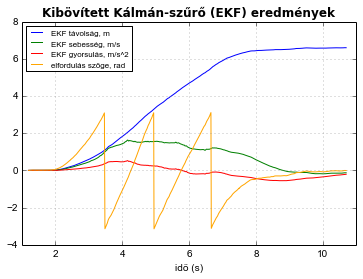

In [8]:
%matplotlib inline
plt.plot(xe[:,0],xe[:,1], 'b-', label=u'EKF távolság, m')
plt.plot(xe[:,0],xe[:,2], 'g-', label=u'EKF sebesség, m/s')
plt.plot(xe[:,0],xe[:,3], 'r-', label=u'EKF gyorsulás, m/s^2')
plt.plot(xe[:,0],xe[:,4], color='orange', label=u'elfordulás szöge, rad')
plt.xlim(1,11)
plt.grid(color='grey')
plt.title(u'Kibövített Kálmán-szűrő (EKF) eredmények', fontweight='bold')
plt.xlabel(u'idő (s)')
plt.legend(loc='upper left', shadow=False, prop={'size':8}) 
plt.show()